### 1 - Import test data

In [2]:
import yfinance as yf
import pandas as pd

dataF = yf.download("USDJPY=X", start="2023-9-4", end="2023-10-2", interval='15m')
dataF.iloc[:,:]
#dataF.Open.iloc

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-09-04 00:00:00,1.077586,1.077935,1.077586,1.077819,1.077819,0
2023-09-04 00:15:00,1.077819,1.077819,1.077470,1.077586,1.077586,0
2023-09-04 00:30:00,1.077470,1.077702,1.077470,1.077702,1.077702,0
2023-09-04 00:45:00,1.077702,1.077935,1.077702,1.077819,1.077819,0
2023-09-04 01:00:00,1.077819,1.077935,1.077586,1.077819,1.077819,0
...,...,...,...,...,...,...
2023-09-29 21:15:00,1.057306,1.057641,1.057194,1.057641,1.057641,0
2023-09-29 21:30:00,1.057641,1.057865,1.057641,1.057753,1.057753,0
2023-09-29 21:45:00,1.057865,1.057865,1.057530,1.057641,1.057641,0


<AxesSubplot:xlabel='Datetime'>

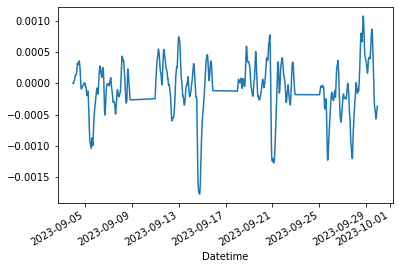

In [13]:
# get the macd values
macd = dataF.Close.ewm(span=12).mean() - dataF.Close.ewm(span=26).mean()
# get the signal values
signal = macd.ewm(span=9).mean()
# get the difference between macd and signal
macd = macd - signal
# plot the macd and signal
signal.plot()

In [18]:
macd

Datetime
2023-09-04 00:00:00    0.000000e+00
2023-09-04 00:15:00   -2.315581e-06
2023-09-04 00:30:00   -8.693591e-08
2023-09-04 00:45:00    3.418770e-06
2023-09-04 01:00:00    4.375855e-06
                           ...     
2023-09-29 21:15:00    7.855213e-05
2023-09-29 21:30:00    9.858742e-05
2023-09-29 21:45:00    1.028418e-04
2023-09-29 22:00:00    9.676288e-05
2023-09-29 22:15:00    9.143368e-05
Name: Close, Length: 1896, dtype: float64

### 2 - Define your signal function

In [16]:
def signal_generator(macd):


    print(macd.iloc[-1])

    # MACD bullish crossover
    if (macd.iloc[-1]>0 and macd.iloc[-2]<0):
        return 2
    
    # MACD bearish crossover
    elif (macd.iloc[-1]<0 and macd.iloc[-2]>0):
        return 1
    
    # open = df.Open.iloc[-1]
    # close = df.Close.iloc[-1]
    # previous_open = df.Open.iloc[-2]
    # previous_close = df.Close.iloc[-2]s
    
    # # Bearish Pattern
    # if (open>close and 
    # previous_open<previous_close and 
    # close<previous_open and
    # open>=previous_close):
    #     return 1

    # # Bullish Pattern
    # elif (open<close and 
    #     previous_open>previous_close and 
    #     close>previous_open and
    #     open<=previous_close):
    #     return 2
    
    # No clear pattern
    else:
        return 0

signal = []
signal.append(0)
for i in range(1,len(dataF)):
    df = dataF[i-1:i+1]
    signal.append(signal_generator(macd))
#signal_generator(data)
dataF["signal"] = signal

9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.143367883775904e-05
9.14336788

In [15]:
dataF.signal.value_counts()
#dataF.iloc[:, :]

0    1896
Name: signal, dtype: int64

### 3 - Connect to the market and execute trades

In [5]:
from apscheduler.schedulers.blocking import BlockingScheduler
from oandapyV20 import API
import oandapyV20.endpoints.orders as orders
from oandapyV20.contrib.requests import MarketOrderRequest
from oanda_candles import Pair, Gran, CandleClient
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails

In [6]:
from config import access_token, accountID
def get_candles(n):
    #access_token='XXXXXXX'#you need token here generated from OANDA account
    client = CandleClient(access_token, real=False)
    collector = client.get_collector(Pair.EUR_USD, Gran.M15)
    candles = collector.grab(n)
    return candles

candles = get_candles(3)
for candle in candles:
    print(float(str(candle.bid.o))>1)


True
True
True


In [12]:
def trading_job():
    candles = get_candles(3)
    dfstream = pd.DataFrame(columns=['Open','Close','High','Low'])
    
    i=0
    for candle in candles:
        dfstream.loc[i, ['Open']] = float(str(candle.bid.o))
        dfstream.loc[i, ['Close']] = float(str(candle.bid.c))
        dfstream.loc[i, ['High']] = float(str(candle.bid.h))
        dfstream.loc[i, ['Low']] = float(str(candle.bid.l))
        i=i+1

    dfstream['Open'] = dfstream['Open'].astype(float)
    dfstream['Close'] = dfstream['Close'].astype(float)
    dfstream['High'] = dfstream['High'].astype(float)
    dfstream['Low'] = dfstream['Low'].astype(float)

    signal = signal_generator(dfstream.iloc[:-1,:])#
    
    # EXECUTING ORDERS
    #accountID = "XXXXXXX" #your account ID here
    client = API(access_token)
         
    SLTPRatio = 2.
    previous_candleR = abs(dfstream['High'].iloc[-2]-dfstream['Low'].iloc[-2])
    
    SLBuy = float(str(candle.bid.o))-previous_candleR
    SLSell = float(str(candle.bid.o))+previous_candleR

    TPBuy = float(str(candle.bid.o))+previous_candleR*SLTPRatio
    TPSell = float(str(candle.bid.o))-previous_candleR*SLTPRatio
    
    print(dfstream.iloc[:-1,:])
    print(TPBuy, "  ", SLBuy, "  ", TPSell, "  ", SLSell)
    signal = 2
    #Sell
    if signal == 1:
        mo = MarketOrderRequest(instrument="EUR_USD", units=-1000, takeProfitOnFill=TakeProfitDetails(price=TPSell).data, stopLossOnFill=StopLossDetails(price=SLSell).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)
    #Buy
    elif signal == 2:
        mo = MarketOrderRequest(instrument="EUR_USD", units=1000, takeProfitOnFill=TakeProfitDetails(price=TPBuy).data, stopLossOnFill=StopLossDetails(price=SLBuy).data)
        r = orders.OrderCreate(accountID, data=mo.data)
        rv = client.request(r)
        print(rv)

### 4 - Executing orders automatically with a scheduler

In [ ]:
trading_job()

#scheduler = BlockingScheduler()
#scheduler.add_job(trading_job, 'cron', day_of_week='mon-fri', hour='00-23', minute='1,16,31,46', start_date='2022-01-12 12:00:00', timezone='America/Chicago')
#scheduler.start()